In [1]:
from jenga.tasks.income import IncomeEstimationTask
from jenga.corruptions.generic import MissingValues
from jenga.evaluation.corruption_impact import CorruptionImpactEvaluator
import matplotlib.pyplot as plt

import numpy as np
import datawig 

### Instantiate the income estimation task, make it ignore incomplete records for model training

In [2]:
task = IncomeEstimationTask(seed=42, ignore_incomplete_records_for_training=True)

### A missing value imputer which imputes the most frequent value per column

In [3]:
class ModeImputer:
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data):
        for column in self.columns:
            mode = data[column].value_counts().index[0]
            self.modes[column] = mode
            
    def transform(self, data):
        imputed = data.copy(deep=True)
        for column in self.columns:
            imputed[column].fillna(self.modes[column], inplace=True) 
        return imputed
            
imputer = ModeImputer(['education', 'workclass', 'marital_status', 'occupation'])
imputer.fit(task.train_data)

### A missing value which learns an imputation model via the datawig library

In [5]:
class DatawigImputer:
    def __init__(self, input_columns, target_column):
        self.input_columns = input_columns
        self.target_column = target_column
        self.model = None
        
    def fit(self, data):
        self.model = datawig.SimpleImputer(
            input_columns=self.input_columns,
            output_column=self.target_column,
            output_path = f'imputer_model_{self.target_column}',
            is_explainable=False).fit(data)
        self.model = self.model.load(f'imputer_model_{self.target_column}')
            
    def transform(self, data):
        imputed = data
        imputed = self.model.predict(imputed, inplace=True)
        imputed.loc[imputed[self.target_column].isnull(), self.target_column] = \
            imputed[self.target_column + '_imputed']
        
        return imputed

### We train imputation models for each column of interest

In [6]:
education_imputer = DatawigImputer(['occupation', 'marital_status', 'workclass'], 'education')
education_imputer.fit(task.train_data)

2020-10-19 19:39:05,883 [INFO]  CategoricalEncoder for column education                                found only 34 occurrences of value Preschool
2020-10-19 19:39:09,922 [INFO]  
========== start: fit model
2020-10-19 19:39:09,923 [WARNING]  Already bound, ignoring bind()
2020-10-19 19:39:13,999 [INFO]  Epoch[0] Batch [0-680]	Speed: 2679.75 samples/sec	cross-entropy=1.743749	education-accuracy=0.389776
2020-10-19 19:39:18,054 [INFO]  Epoch[0] Train-cross-entropy=1.680336
2020-10-19 19:39:18,055 [INFO]  Epoch[0] Train-education-accuracy=0.394543
2020-10-19 19:39:18,056 [INFO]  Epoch[0] Time cost=8.131
2020-10-19 19:39:18,072 [INFO]  Saved checkpoint to "imputer_model_education/model-0000.params"
2020-10-19 19:39:18,711 [INFO]  Epoch[0] Validation-cross-entropy=1.691406
2020-10-19 19:39:18,712 [INFO]  Epoch[0] Validation-education-accuracy=0.393626
2020-10-19 19:39:22,807 [INFO]  Epoch[1] Batch [0-680]	Speed: 2660.46 samples/sec	cross-entropy=1.664310	education-accuracy=0.396659
2020-1

In [7]:
occupation_imputer = DatawigImputer(['education', 'marital_status', 'workclass'], 'occupation')
occupation_imputer.fit(task.train_data)

In [8]:
marital_status_imputer = DatawigImputer(['education', 'occupation', 'workclass'], 'marital_status')
marital_status_imputer.fit(task.train_data)

In [9]:
workclass_imputer = DatawigImputer(['education', 'occupation', 'marital_status'], 'workclass')
workclass_imputer.fit(task.train_data)

### Some glue code (decorators) to be able to apply the imputers in our task

In [10]:
class ChainedModelDecorator:
    def __init__(self, model, imputers):
        self.model = model
        self.imputers = imputers
        
    def predict_proba(self, data):
        imputed = data
        for imputer in self.imputers:
            imputed = imputer.transform(imputed)
        
        return self.model.predict_proba(imputed)

In [11]:
class ModelDecorator:
    def __init__(self, model, imputer):
        self.model = model
        self.imputer = imputer
        
    def predict_proba(self, data):
        return self.model.predict_proba(self.imputer.transform(data))

### We generate the data corruptions to evaluate: missing values of different kinds and strengths for the columns of interest

In [18]:
evaluator = CorruptionImpactEvaluator(task)

corruptions = []
for impacted_column in ['education', 'workclass', 'marital_status', 'occupation']:
    for fraction in [0.99, 0.5, 0.25, 0.1, 0.01]:
        for missingness in ['MCAR', 'MAR', 'MNAR']:
            corruption = MissingValues(impacted_column, fraction, missingness=missingness, na_value=np.nan)
            corruptions.append(corruption)

### Train the baseline model

In [19]:
model = task.fit_baseline_model(task.train_data, task.train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.1s finished


### We create two additional models, one that uses the datawig imputers and another one that uses the  mode imputer

In [20]:
datawig_model = ChainedModelDecorator(model, [education_imputer, workclass_imputer, 
                                                        marital_status_imputer, occupation_imputer])
mode_model = ModelDecorator(model, imputer)

### Evaluate the impact of the corruptions on the baseline model and the model with mode imputation

In [21]:
results = evaluator.evaluate(model, 10, *corruptions)
decorated_results = evaluator.evaluate(mode_model, 10, *corruptions)

0/600 (0.018958999999995285)
10/600 (0.1908939999998438)
20/600 (0.39341399999989335)
30/600 (0.5894269999998869)
40/600 (0.768291999999974)
50/600 (0.9796839999999065)
60/600 (1.1884759999998096)
70/600 (1.3675479999999425)
80/600 (1.5585579999999482)
90/600 (1.757327000000032)
100/600 (1.9471199999998134)
110/600 (2.1367669999999634)
120/600 (2.3312049999999545)
130/600 (2.5115359999999782)
140/600 (2.7168389999999363)
150/600 (2.904880999999932)
160/600 (3.071954000000005)
170/600 (3.2657729999998537)
180/600 (3.4666879999999765)
190/600 (3.6373519999999644)
200/600 (3.8401779999999235)
210/600 (4.040876000000026)
220/600 (4.221401999999898)
230/600 (4.408975999999939)
240/600 (4.598799999999983)
250/600 (4.790009999999938)
260/600 (4.995473999999831)
270/600 (5.184755999999879)
280/600 (5.357086999999865)
290/600 (5.538969999999836)
300/600 (5.74452499999984)
310/600 (5.921030999999857)
320/600 (6.117923000000019)
330/600 (6.314012999999932)
340/600 (6.496251999999913)
350/600 (6.6

### Evaluate the impact of the corruptions on the model with datawig imputation

In [22]:
datawig_results = evaluator.evaluate(datawig_model, 10, *corruptions)

0/600 (11.728351999999859)
10/600 (128.95038399999999)
20/600 (247.1644859999999)
30/600 (364.05828299999985)
40/600 (481.7746539999998)
50/600 (597.3863729999998)
60/600 (712.2968919999998)
70/600 (830.8601899999999)
80/600 (946.9200179999998)
90/600 (1064.299728)
100/600 (1183.652807)
110/600 (1299.9488820000001)
120/600 (1419.016525)
130/600 (1535.5235659999998)
140/600 (1651.7540009999998)
150/600 (1769.6829239999997)
160/600 (1886.949201)
170/600 (2003.1980749999998)
180/600 (2119.990336)
190/600 (2234.308311)
200/600 (2347.535103)
210/600 (2464.579509)
220/600 (2580.85272)
230/600 (2696.7399729999997)
240/600 (2811.952384)
250/600 (2929.799634)
260/600 (3046.239444)
270/600 (3161.386165)
280/600 (3279.209919)
290/600 (3395.686205)
300/600 (3514.6062599999996)
310/600 (3628.9181369999997)
320/600 (3740.674513)
330/600 (3851.729827)
340/600 (3964.7832829999998)
350/600 (4078.2920860000004)
360/600 (4192.627105)
370/600 (4308.574106)
380/600 (4423.706551)
390/600 (4540.202371)
400/6

### Code to plot the results

In [28]:
def find_result(column, fraction, missingness, results):
    for result in results:
        corr = result.corruption
        if corr.column == column and corr.fraction == fraction and corr.sampling == missingness:
            return result

In [29]:
def plot_impact(column, plt, results, suffix=''):
    ax = plt.gca()
    
    scores = []
    labels = []

    for impacted_column in [column]:
        for fraction in [0.01, 0.1, 0.5, 0.99]:  
            for missingness in ['MNAR', 'MAR', 'MCAR']:                    
                result = find_result(impacted_column, fraction, missingness, results)
                scores.append(result.corrupted_scores)
                labels.append(f"{missingness} {int(fraction*100)}%")

    baseline_score = result.baseline_score            

    ax.axhline(baseline_score, linestyle='--', color='red')
    bplot = ax.boxplot(scores, showfliers=False, patch_artist=True, medianprops={'color':'black'})

    colors = ['#1e4052', '#dc6082', '#e1a677',
              '#1e4052', '#dc6082', '#e1a677', 
              '#1e4052', '#dc6082', '#e1a677', 
              '#1e4052', '#dc6082', '#e1a677']
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.yaxis.grid(True)

    ax.set_xticklabels(labels)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.set_ylim((0.79, 0.895))
    ax.set_title(f"Missing values in '{column}'", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)    
    ax.set_ylabel('AUC', fontsize=24)
    
    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()
    plt.show()

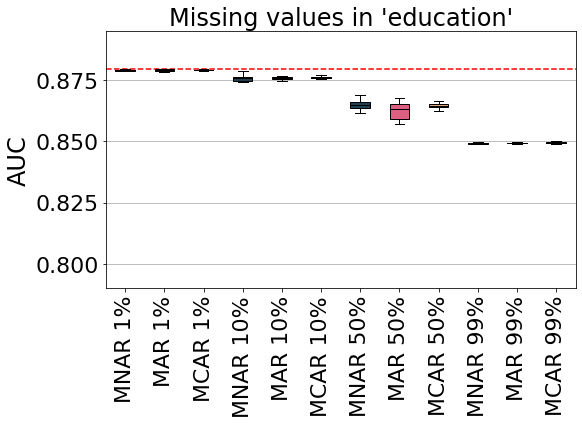

In [31]:
plot_impact('education', plt, results)

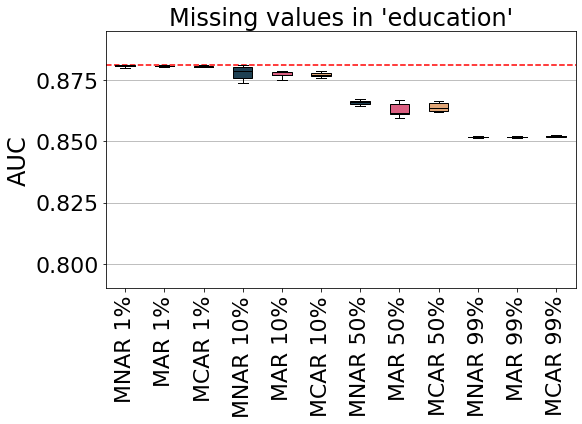

In [32]:
plot_impact('education', plt, decorated_results, '-mode')

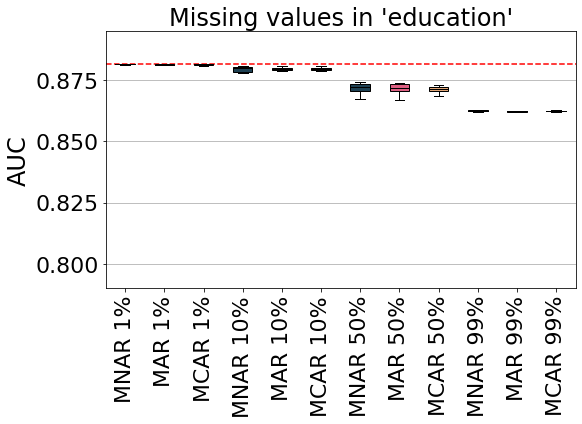

In [33]:
plot_impact('education', plt, datawig_results, '-datawig')

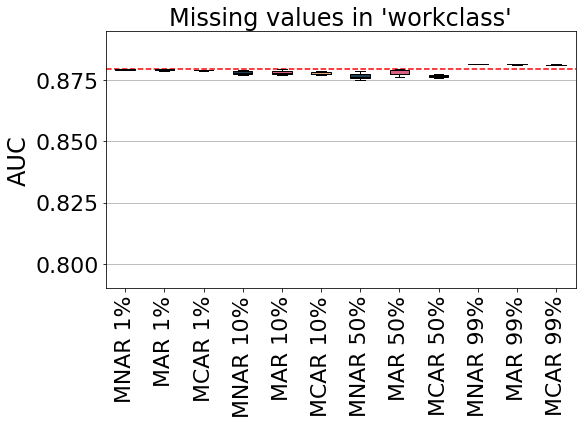

In [34]:
plot_impact('workclass', plt, results)

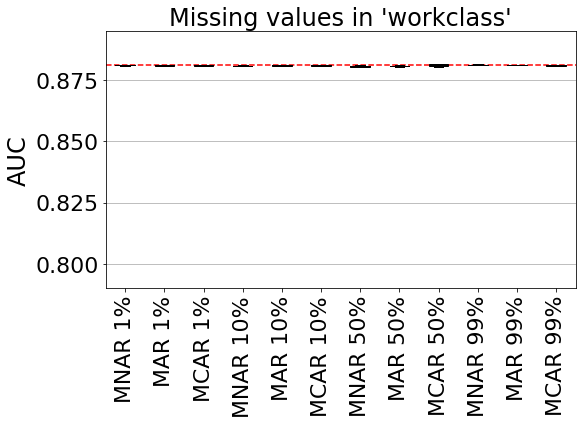

In [35]:
plot_impact('workclass', plt, decorated_results, '-mode')

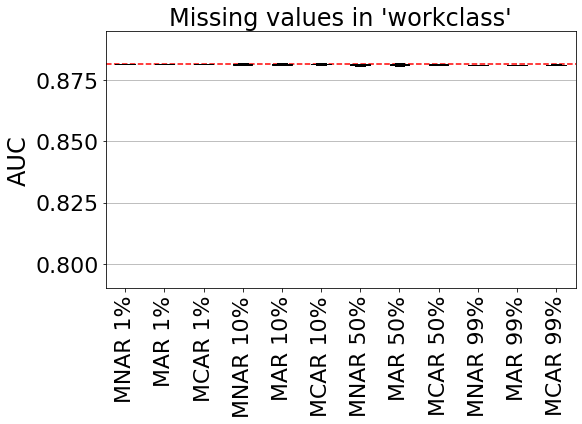

In [36]:
plot_impact('workclass', plt, datawig_results, '-datawig')

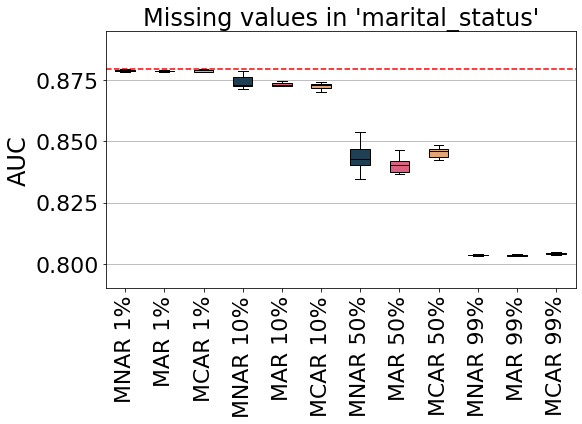

In [37]:
plot_impact('marital_status', plt, results)

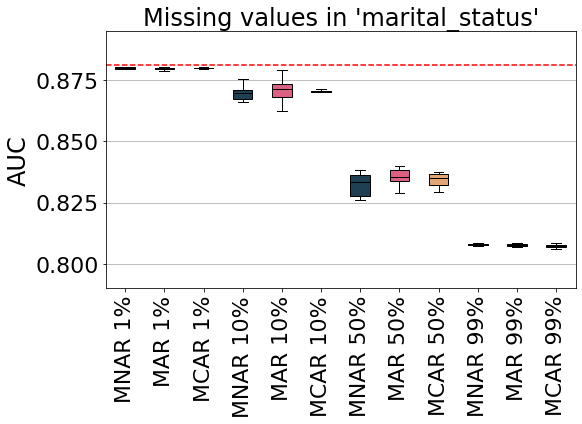

In [38]:
plot_impact('marital_status', plt, decorated_results, '-mode')

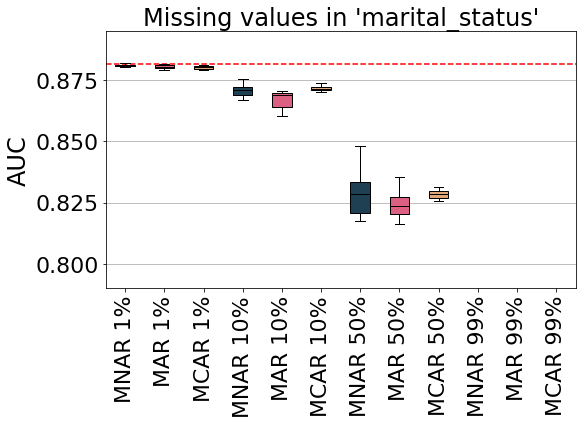

In [39]:
plot_impact('marital_status', plt, datawig_results, '-datawig')

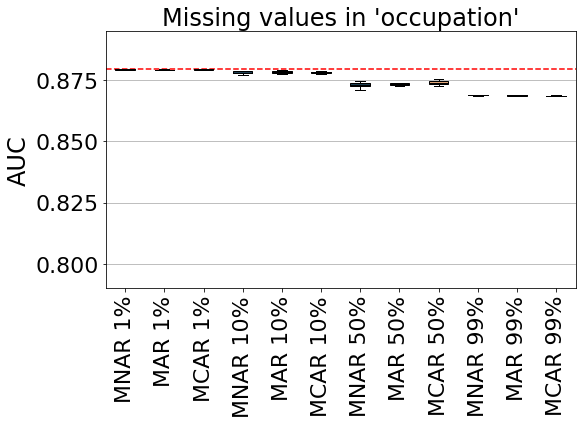

In [40]:
plot_impact('occupation', plt, results)

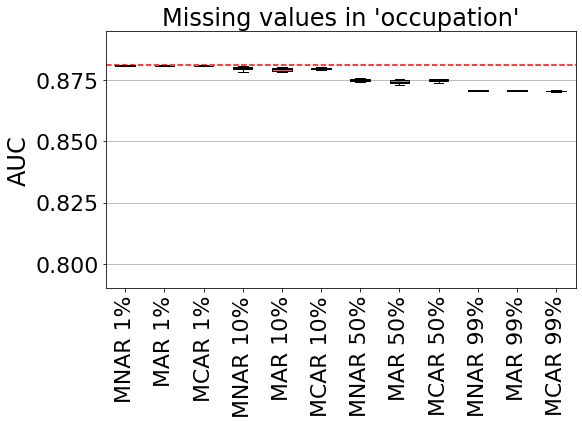

In [41]:
plot_impact('occupation', plt, decorated_results, '-mode')

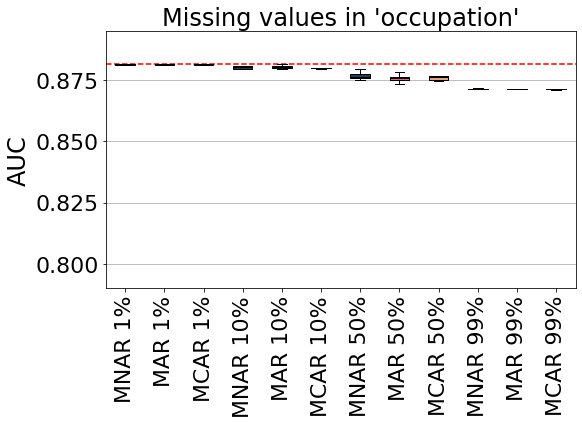

In [42]:
plot_impact('occupation', plt, datawig_results, '-datawig')

### Save the results for later analysis

In [44]:
import jsonpickle

with open("datawig-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(datawig_results))  
    
with open("mode-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(decorated_results))    
    
with open("no-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(results))        